In [ ]:
# STEP 1: Install the required library in the Colab environment.
# The '!' character lets you run shell commands directly in a Colab cell.
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

# STEP 2: Import libraries and run the experiment.
import torch
import clip
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import numpy as np
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import random

# --- Setup and Utilities ---

def set_seed(seed: int):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
# Google Colab typically provides a GPU; this will automatically use it.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

PACS_DOMAINS = ['art_painting', 'cartoon', 'photo', 'sketch']
PACS_CLASS_NAMES = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

# --- Custom Dataset ---

class CustomPACSDataset(Dataset):
    """A custom Dataset wrapper that takes a list of pre-filtered examples and a preprocess function."""
    def __init__(self, examples, preprocess_fn):
        self.examples = examples
        self.preprocess = preprocess_fn

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        image = self.preprocess(ex["image"].convert("RGB"))
        label = ex["label"]
        return image, label

# --- Part 1: Zero-Shot Evaluation ---

@torch.no_grad()
def run_zero_shot_evaluation(model, preprocess_fn, hf_dataset, prompt_templates):
    """Evaluates CLIP's zero-shot performance across all PACS domains."""
    print("\n--- Running Zero-Shot Evaluation ---")
    model.eval()
    results = {}

    for domain in PACS_DOMAINS:
        print(f"\nEvaluating on domain: {domain}")

        # 1. Prepare text features using the domain-specific prompt
        prompt_template = prompt_templates[domain]
        print(f"Using prompt: '{prompt_template}'")
        text_inputs = torch.cat([clip.tokenize(prompt_template.format(c)) for c in PACS_CLASS_NAMES]).to(device)
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # 2. Prepare domain-specific dataset and dataloader
        domain_examples = [ex for ex in hf_dataset if ex["domain"] == domain]
        domain_dataset = CustomPACSDataset(domain_examples, preprocess_fn)
        loader = DataLoader(domain_dataset, batch_size=64, shuffle=False, num_workers=1)

        # 3. Evaluate
        total_correct, total_samples = 0, 0
        for images, labels in tqdm(loader, desc=f"Zero-Shot {domain}"):
            images, labels = images.to(device), labels.to(device)

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            predictions = similarity.argmax(dim=-1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

        accuracy = total_correct / total_samples
        results[domain] = accuracy
        print(f"Accuracy on {domain}: {accuracy:.4f}")

    return results

# --- Part 2: Linear Probing (Fine-tuning) ---

@torch.no_grad()
def extract_features(model, loader, desc=""):
    """Extracts CLIP image features for a given dataset."""
    model.eval()
    all_features, all_labels = [], []
    for images, labels in tqdm(loader, desc=desc):
        images = images.to(device)
        features = model.encode_image(images)
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())
    return torch.cat(all_features).numpy(), torch.cat(all_labels).numpy()

def run_linear_probe(model, preprocess_fn, hf_dataset, source_domain, target_domain):
    """Trains a linear classifier on source features and evaluates on target."""
    print("\n--- Running Linear Probe Evaluation ---")
    print(f"Source Domain (for training): {source_domain}")
    print(f"Target Domain (for testing): {target_domain}")

    # 1. Prepare datasets and dataloaders
    source_examples = [ex for ex in hf_dataset if ex["domain"] == source_domain]
    target_examples = [ex for ex in hf_dataset if ex["domain"] == target_domain]

    source_dataset = CustomPACSDataset(source_examples, preprocess_fn)
    target_dataset = CustomPACSDataset(target_examples, preprocess_fn)

    source_loader = DataLoader(source_dataset, batch_size=64, num_workers=1)
    target_loader = DataLoader(target_dataset, batch_size=64, num_workers=1)

    # 2. Extract features
    X_train, y_train = extract_features(model, source_loader, desc=f"Extracting {source_domain} features")
    X_test, y_test = extract_features(model, target_loader, desc=f"Extracting {target_domain} features")

    # 3. Train a logistic regression classifier
    print("Training linear classifier...")
    classifier = LogisticRegression(random_state=42, C=0.1, max_iter=1000, verbose=0)
    classifier.fit(X_train, y_train)

    # 4. Evaluate
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    print(f"\nLinear Probe Target Accuracy ({target_domain}): {accuracy:.4f}")
    return accuracy


if __name__ == '__main__':
    # Load CLIP Model and Dataset
    print("Loading CLIP model (ViT-B/32)...")
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

    print("Loading PACS dataset...")
    pacs_dataset = load_dataset("flwrlabs/pacs")["train"]

    # --- Run Zero-Shot ---
    prompt_templates = {
        'photo': "a photo of a {}.",
        'art_painting': "an art painting of a {}.",
        'cartoon': "a cartoon of a {}.",
        'sketch': "a sketch of a {}."
    }
    zero_shot_results = run_zero_shot_evaluation(clip_model, clip_preprocess, pacs_dataset, prompt_templates)

    # --- Run Linear Probe ---
    source_domain = "photo"
    target_domain = "sketch"
    linear_probe_accuracy = run_linear_probe(clip_model, clip_preprocess, pacs_dataset, source_domain, target_domain)

    # --- Final Summary ---
    print("\n\n===== Experiment Summary =====")
    print("Zero-Shot Accuracies:")
    for domain, acc in zero_shot_results.items():
        print(f"  - {domain.title().replace('_', ' ')}: {acc:.4f}")

    print(f"\nLinear Probe Accuracy ({source_domain} -> {target_domain}): {linear_probe_accuracy:.4f}")
    print(f"For comparison, Zero-Shot on {target_domain}: {zero_shot_results[target_domain]:.4f}")


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jkj45pjv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jkj45pjv
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Using device: cuda
Loading CLIP model (ViT-B/32)...


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 49.2MiB/s]


Loading PACS dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



--- Running Zero-Shot Evaluation ---

Evaluating on domain: art_painting
Using prompt: 'an art painting of a {}.'


Zero-Shot art_painting:   0%|          | 0/32 [00:00<?, ?it/s]

Accuracy on art_painting: 0.9556

Evaluating on domain: cartoon
Using prompt: 'a cartoon of a {}.'


Zero-Shot cartoon:   0%|          | 0/37 [00:00<?, ?it/s]

Accuracy on cartoon: 0.9795

Evaluating on domain: photo
Using prompt: 'a photo of a {}.'


Zero-Shot photo:   0%|          | 0/27 [00:00<?, ?it/s]

Accuracy on photo: 0.9982

Evaluating on domain: sketch
Using prompt: 'a sketch of a {}.'


Zero-Shot sketch:   0%|          | 0/62 [00:00<?, ?it/s]

Accuracy on sketch: 0.8544

--- Running Linear Probe Evaluation ---
Source Domain (for training): photo
Target Domain (for testing): sketch


Extracting photo features:   0%|          | 0/27 [00:00<?, ?it/s]

Extracting sketch features:   0%|          | 0/62 [00:00<?, ?it/s]

Training linear classifier...

Linear Probe Target Accuracy (sketch): 0.8043


===== Experiment Summary =====
Zero-Shot Accuracies:
  - Art Painting: 0.9556
  - Cartoon: 0.9795
  - Photo: 0.9982
  - Sketch: 0.8544

Linear Probe Accuracy (photo -> sketch): 0.8043
For comparison, Zero-Shot on sketch: 0.8544


Task 2

In [ ]:
# STEP 1: Ensure libraries are installed.
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-p7e1qo4u
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-p7e1qo4u
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
# STEP 2: Import libraries and run the experiment.
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import clip
import numpy as np
from tqdm.auto import tqdm
import random
import torch.optim as optim

# --- Setup and Utilities ---

def set_seed(seed: int):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

PACS_DOMAINS = ['art_painting', 'cartoon', 'photo', 'sketch']
PACS_CLASS_NAMES = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

# --- Custom Dataset (from previous step) ---

class CustomPACSDataset(Dataset):
    def __init__(self, examples, preprocess_fn):
        self.examples = examples
        self.preprocess = preprocess_fn
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        ex = self.examples[idx]
        image = self.preprocess(ex["image"].convert("RGB"))
        label = ex["label"]
        return image, label

# --- Core Prompt Learning Implementation (Corrected) ---

class PromptLearner(nn.Module):
    """
    Implements the learnable prompt vectors.
    This is the core of Context Optimization (CoOp).
    """
    def __init__(self, class_names, clip_model):
        super().__init__()
        n_cls = len(class_names)
        n_ctx = 16  # Number of context vectors (hyperparameter)
        ctx_init = "a photo of a"  # Initialization text
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]

        # Tokenize the initialization text
        ctx_init = ctx_init.replace("_", " ")
        n_ctx = len(ctx_init.split()) # n_ctx is now 4
        prompt = clip.tokenize(ctx_init).to(device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(prompt).type(dtype)

        # These are the learnable vectors
        self.ctx = nn.Parameter(embedding[0, 1:1+n_ctx, :]) # (4, ctx_dim)

        # --- FIX: Correctly extract class name embeddings ---
        class_name_tokens = clip.tokenize([f" {c}" for c in class_names]).to(device)
        with torch.no_grad():
            class_embeddings = clip_model.token_embedding(class_name_tokens).type(dtype)

        # The class token (e.g., "dog") is at index 1 after the <SOT> token
        # Shape: (n_cls, 1, ctx_dim)
        self.class_name_embedding = class_embeddings[:, 1, :].unsqueeze(1)
        # --- END FIX ---

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        # Suffix includes the <EOT> token and padding
        self.token_suffix = embedding[0, 1+n_ctx:, :] # (72, ctx_dim)

    def forward(self):
        """
        Constructs the full text embeddings for all classes.
        Shape: (n_cls, 77, ctx_dim)
        """
        prefix = self.ctx.unsqueeze(0).expand(self.n_cls, -1, -1) # (n_cls, 4, ctx_dim)

        # Combine learnable prefix with fixed class names and suffix
        # Shapes are now (n_cls, 4, dim) + (n_cls, 1, dim) + (n_cls, 72, dim)
        # This correctly results in (n_cls, 77, dim)
        prompts = torch.cat(
            [
                prefix,
                self.class_name_embedding,
                self.token_suffix.unsqueeze(0).expand(self.n_cls, -1, -1),
            ],
            dim=1
        )
        return prompts

class CustomCLIP(nn.Module):
    """Wraps CLIP model and the PromptLearner. (Corrected)"""
    def __init__(self, class_names, clip_model):
        super().__init__()
        self.prompt_learner = PromptLearner(class_names, clip_model)
        self.image_encoder = clip_model.visual

        # --- FIX: Get all components for the text pipeline ---
        self.text_encoder = clip_model.transformer # Bug 1: Was clip_model.text
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        # --- END FIX ---

        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image):
        # Get image features from the frozen image encoder
        image_features = self.image_encoder(image.type(self.dtype))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # --- FIX: Replicate the full text encoding pipeline ---

        # 1. Get custom prompt embeddings: (n_cls, 77, ctx_dim)
        prompts = self.prompt_learner()

        # 2. Add positional embeddings
        x = prompts + self.positional_embedding.type(self.dtype)

        # 3. Permute to (L, N, D) format for the transformer
        x = x.permute(1, 0, 2)  # (77, n_cls, ctx_dim)

        # 4. Pass through the transformer
        x = self.text_encoder(x)

        # 5. Permute back to (N, L, D)
        x = x.permute(1, 0, 2)  # (n_cls, 77, ctx_dim)

        # 6. Apply final LayerNorm
        x = self.ln_final(x).type(self.dtype)

        # 7. Get the feature at the <EOT> token position and project
        # In our prompt: [4 ctx_tokens] + [1 class_token] + [1 EOT_token] + ...
        # The EOT token is at index 5 (which is n_ctx + 1)
        eot_token_index = self.prompt_learner.n_ctx + 1
        text_features = x[torch.arange(x.shape[0]), eot_token_index] @ self.text_projection

        # --- END FIX ---

        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Compute similarity and logits
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()
        return logits

# --- Main Experiment Runner ---

def run_prompt_learning(clip_model, preprocess_fn, hf_dataset, source_domain, target_domain):
    print("\n--- Running Prompt Learning (CoOp) ---")
    print(f"Training on Source: {source_domain}, Evaluating on Target: {target_domain}")

    # 1. Freeze CLIP model parameters
    for param in clip_model.parameters():
        param.requires_grad_(False)

    # 2. Initialize our custom model and optimizer
    # The optimizer will ONLY see the parameters of the prompt_learner
    custom_clip_model = CustomCLIP(PACS_CLASS_NAMES, clip_model).to(device)
    optimizer = optim.SGD(custom_clip_model.prompt_learner.parameters(), lr=0.002)
    criterion = nn.CrossEntropyLoss()

    # 3. Prepare DataLoaders
    source_examples = [ex for ex in hf_dataset if ex["domain"] == source_domain]
    target_examples = [ex for ex in hf_dataset if ex["domain"] == target_domain]

    source_dataset = CustomPACSDataset(source_examples, preprocess_fn)
    target_dataset = CustomPACSDataset(target_examples, preprocess_fn)

    source_loader = DataLoader(source_dataset, batch_size=32, shuffle=True, num_workers=0)
    target_loader = DataLoader(target_dataset, batch_size=32, shuffle=False, num_workers=0)

    # 4. Training Loop (on source data only)
    epochs = 10
    for epoch in range(epochs):
        custom_clip_model.train()
        total_loss = 0
        for images, labels in tqdm(source_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = custom_clip_model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} Average Loss: {total_loss / len(source_loader):.4f}")

    # 5. Evaluation on Target Domain
    print(f"\nEvaluating on target domain: {target_domain}")
    custom_clip_model.eval()
    total_correct, total_samples = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(target_loader, desc=f"Evaluating on {target_domain}"):
            images, labels = images.to(device), labels.to(device)
            logits = custom_clip_model(images)
            predictions = logits.argmax(dim=-1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f"Prompt Learning Target Accuracy ({target_domain}): {accuracy:.4f}")
    return accuracy

if __name__ == '__main__':
    # Load CLIP Model and Dataset
    print("Loading CLIP model (ViT-B/16)...")
    # Using ViT-B/16 as it's often better for prompt tuning
    clip_model, clip_preprocess = clip.load("ViT-B/16", device=device)

    print("Loading PACS dataset...")
    pacs_dataset = load_dataset("flwrlabs/pacs")["train"]

    # Run the Prompt Learning experiment
    source_domain = "photo"
    target_domain = "sketch"
    coop_accuracy = run_prompt_learning(clip_model, clip_preprocess, pacs_dataset, source_domain, target_domain)

    print("\n\n===== Prompt Learning Summary =====")
    print(f"Target Accuracy ({source_domain} -> {target_domain}): {coop_accuracy:.4f}")
    print("Compare this result to your Zero-Shot and Linear Probe baselines.")

Using device: cuda
Loading CLIP model (ViT-B/16)...
Loading PACS dataset...

--- Running Prompt Learning (CoOp) ---
Training on Source: photo, Evaluating on Target: sketch


Epoch 1/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1 Average Loss: 0.0104


Epoch 2/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2 Average Loss: 0.0050


Epoch 3/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3 Average Loss: 0.0030


Epoch 4/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4 Average Loss: 0.0023


Epoch 5/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5 Average Loss: 0.0019


Epoch 6/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6 Average Loss: 0.0015


Epoch 7/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7 Average Loss: 0.0013


Epoch 8/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8 Average Loss: 0.0010


Epoch 9/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9 Average Loss: 0.0010


Epoch 10/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10 Average Loss: 0.0008

Evaluating on target domain: sketch


Evaluating on sketch:   0%|          | 0/123 [00:00<?, ?it/s]

Prompt Learning Target Accuracy (sketch): 0.8794


===== Prompt Learning Summary =====
Target Accuracy (photo -> sketch): 0.8794
Compare this result to your Zero-Shot and Linear Probe baselines.


Task 2 (continue)

In [ ]:
# STEP 2: Import libraries and run the experiment.
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import clip
import numpy as np
from tqdm.auto import tqdm
import random
import torch.optim as optim

# --- Setup and Utilities ---

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

PACS_DOMAINS = ['art_painting', 'cartoon', 'photo', 'sketch']
PACS_CLASS_NAMES = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

# --- Custom Dataset (from previous step) ---

class CustomPACSDataset(Dataset):
    def __init__(self, examples, preprocess_fn):
        self.examples = examples
        self.preprocess = preprocess_fn
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        # The 'label' key might be missing for pseudo-data, but we handle that
        label = self.examples[idx].get("label", -1)
        image = self.preprocess(self.examples[idx]["image"].convert("RGB"))
        return image, label

class PseudoLabelDataset(Dataset):
    """Dataset for pseudo-labeled data."""
    def __init__(self, pseudo_data, preprocess_fn):
        self.pseudo_data = pseudo_data # List of tuples (image_pil, pseudo_label)
        self.preprocess = preprocess_fn
    def __len__(self):
        return len(self.pseudo_data)
    def __getitem__(self, idx):
        pil_image, pseudo_label = self.pseudo_data[idx]
        image = self.preprocess(pil_image)
        return image, pseudo_label

# --- Core Prompt Learning Implementation (Corrected) ---

class PromptLearner(nn.Module):
    """
    Implements the learnable prompt vectors.
    This is the core of Context Optimization (CoOp).
    """
    def __init__(self, class_names, clip_model):
        super().__init__()
        n_cls = len(class_names)
        n_ctx = 16  # Number of context vectors (hyperparameter)
        ctx_init = "a photo of a"  # Initialization text
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]

        # Tokenize the initialization text
        ctx_init = ctx_init.replace("_", " ")
        n_ctx = len(ctx_init.split()) # n_ctx is now 4
        prompt = clip.tokenize(ctx_init).to(device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(prompt).type(dtype)

        # These are the learnable vectors
        self.ctx = nn.Parameter(embedding[0, 1:1+n_ctx, :]) # (4, ctx_dim)

        # --- FIX: Correctly extract class name embeddings ---
        class_name_tokens = clip.tokenize([f" {c}" for c in class_names]).to(device)
        with torch.no_grad():
            class_embeddings = clip_model.token_embedding(class_name_tokens).type(dtype)

        # The class token (e.g., "dog") is at index 1 after the <SOT> token
        # Shape: (n_cls, 1, ctx_dim)
        self.class_name_embedding = class_embeddings[:, 1, :].unsqueeze(1)
        # --- END FIX ---

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        # Suffix includes the <EOT> token and padding
        self.token_suffix = embedding[0, 1+n_ctx:, :] # (72, ctx_dim)

    def forward(self):
        """
        Constructs the full text embeddings for all classes.
        Shape: (n_cls, 77, ctx_dim)
        """
        prefix = self.ctx.unsqueeze(0).expand(self.n_cls, -1, -1) # (n_cls, 4, ctx_dim)

        # Combine learnable prefix with fixed class names and suffix
        # Shapes are now (n_cls, 4, dim) + (n_cls, 1, dim) + (n_cls, 72, dim)
        # This correctly results in (n_cls, 77, dim)
        prompts = torch.cat(
            [
                prefix,
                self.class_name_embedding,
                self.token_suffix.unsqueeze(0).expand(self.n_cls, -1, -1),
            ],
            dim=1
        )
        return prompts

class CustomCLIP(nn.Module):
    """Wraps CLIP model and the PromptLearner. (Corrected)"""
    def __init__(self, class_names, clip_model):
        super().__init__()
        self.prompt_learner = PromptLearner(class_names, clip_model)
        self.image_encoder = clip_model.visual

        # --- FIX: Get all components for the text pipeline ---
        self.text_encoder = clip_model.transformer # Bug 1: Was clip_model.text
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        # --- END FIX ---

        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image):
        # Get image features from the frozen image encoder
        image_features = self.image_encoder(image.type(self.dtype))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # --- FIX: Replicate the full text encoding pipeline ---

        # 1. Get custom prompt embeddings: (n_cls, 77, ctx_dim)
        prompts = self.prompt_learner()

        # 2. Add positional embeddings
        x = prompts + self.positional_embedding.type(self.dtype)

        # 3. Permute to (L, N, D) format for the transformer
        x = x.permute(1, 0, 2)  # (77, n_cls, ctx_dim)

        # 4. Pass through the transformer
        x = self.text_encoder(x)

        # 5. Permute back to (N, L, D)
        x = x.permute(1, 0, 2)  # (n_cls, 77, ctx_dim)

        # 6. Apply final LayerNorm
        x = self.ln_final(x).type(self.dtype)

        # 7. Get the feature at the <EOT> token position and project
        # In our prompt: [4 ctx_tokens] + [1 class_token] + [1 EOT_token] + ...
        # The EOT token is at index 5 (which is n_ctx + 1)
        eot_token_index = self.prompt_learner.n_ctx + 1
        text_features = x[torch.arange(x.shape[0]), eot_token_index] @ self.text_projection

        # --- END FIX ---

        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Compute similarity and logits
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()
        return logits

# --- Helper Functions for Training and Evaluation ---

def train_prompt_learner(model, loader, optimizer, criterion, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Avg Loss: {total_loss / len(loader):.4f}")

@torch.no_grad()
def evaluate_model(model, loader, domain_name):
    model.eval()
    total_correct, total_samples = 0, 0
    for images, labels in tqdm(loader, desc=f"Evaluating on {domain_name}"):
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = logits.argmax(dim=-1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)
    return total_correct / total_samples

@torch.no_grad()
def generate_pseudo_labels(teacher_model, target_examples, preprocess_fn, threshold=0.95):
    print(f"\n--- Generating Pseudo-Labels with threshold > {threshold} ---")
    teacher_model.eval()
    confident_data = []

    # Use a dataset for batching
    target_dataset = CustomPACSDataset(target_examples, preprocess_fn)
    # Set num_workers=0 to avoid multiprocessing errors
    loader = DataLoader(target_dataset, batch_size=64, shuffle=False, num_workers=0)

    original_indices = list(range(len(target_examples)))
    current_idx = 0

    for images, _ in tqdm(loader, desc="Predicting on target"):
        images = images.to(device)
        logits = teacher_model(images)
        probs = logits.softmax(dim=-1)
        max_probs, pseudo_labels = probs.max(dim=-1)

        for i in range(images.size(0)):
            if max_probs[i] > threshold:
                original_example_index = original_indices[current_idx]
                pil_image = target_examples[original_example_index]["image"]
                confident_data.append((pil_image, pseudo_labels[i].item()))
            current_idx += 1

    print(f"Found {len(confident_data)} confident samples out of {len(target_examples)} ({len(confident_data)/len(target_examples):.2%}).")
    return confident_data


if __name__ == '__main__':
    # Load CLIP Model and Dataset
    clip_model, clip_preprocess = clip.load("ViT-B/16", device=device)
    pacs_dataset = load_dataset("flwrlabs/pacs")["train"]
    source_domain, target_domain = "photo", "sketch"

    # --- Part 2a: Train the source-only "Teacher" model ---
    print("\n===== Step 1: Training Source-Only 'Teacher' Model =====")
    teacher_model = CustomCLIP(PACS_CLASS_NAMES, clip_model).to(device)
    optimizer = optim.SGD(teacher_model.prompt_learner.parameters(), lr=0.002)
    criterion = nn.CrossEntropyLoss()

    source_examples = [ex for ex in pacs_dataset if ex["domain"] == source_domain]
    # Set num_workers=0 to avoid multiprocessing errors
    source_loader = DataLoader(CustomPACSDataset(source_examples, clip_preprocess), batch_size=32, shuffle=True, num_workers=0)
    train_prompt_learner(teacher_model, source_loader, optimizer, criterion, epochs=10)

    # Evaluate the teacher
    target_examples = [ex for ex in pacs_dataset if ex["domain"] == target_domain]
    # Set num_workers=0 to avoid multiprocessing errors
    target_loader = DataLoader(CustomPACSDataset(target_examples, clip_preprocess), batch_size=32, num_workers=0)
    teacher_accuracy = evaluate_model(teacher_model, target_loader, target_domain)
    print(f"\nTeacher Model (Source-Only) Target Accuracy: {teacher_accuracy:.4f}")

    # --- Part 2b: UDA with Pseudo-Labels ---
    print("\n===== Step 2: Training UDA 'Student' Model with Pseudo-Labels =====")

    # 1. Generate pseudo-labels using the teacher
    pseudo_labeled_data = generate_pseudo_labels(teacher_model, target_examples, clip_preprocess, threshold=0.95)

    # 2. Create combined dataset
    pseudo_dataset = PseudoLabelDataset(pseudo_labeled_data, clip_preprocess)
    combined_dataset = torch.utils.data.ConcatDataset([
        CustomPACSDataset(source_examples, clip_preprocess),
        pseudo_dataset
    ])
    # Set num_workers=0 to avoid multiprocessing errors
    combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True, num_workers=0)

    # 3. Train the "Student" model on the combined data
    student_model = CustomCLIP(PACS_CLASS_NAMES, clip_model).to(device)
    optimizer = optim.SGD(student_model.prompt_learner.parameters(), lr=0.002)
    train_prompt_learner(student_model, combined_loader, optimizer, criterion, epochs=10)

    # 4. Final evaluation of the student
    student_accuracy = evaluate_model(student_model, target_loader, target_domain)

    # --- Final Summary ---
    print("\n\n===== FINAL EXPERIMENT SUMMARY =====")
    print(f"Teacher (Source-Only Prompt) Target Accuracy: {teacher_accuracy:.4f}")
    print(f"Student (UDA Prompt) Target Accuracy:       {student_accuracy:.4f}")
    improvement = student_accuracy - teacher_accuracy
    print(f"Improvement from UDA: {improvement:+.4f}")

Using device: cuda

===== Step 1: Training Source-Only 'Teacher' Model =====


Epoch 1/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1 Avg Loss: 0.0104


Epoch 2/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2 Avg Loss: 0.0050


Epoch 3/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3 Avg Loss: 0.0030


Epoch 4/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4 Avg Loss: 0.0023


Epoch 5/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5 Avg Loss: 0.0019


Epoch 6/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6 Avg Loss: 0.0015


Epoch 7/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7 Avg Loss: 0.0013


Epoch 8/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8 Avg Loss: 0.0010


Epoch 9/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9 Avg Loss: 0.0010


Epoch 10/10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10 Avg Loss: 0.0008


Evaluating on sketch:   0%|          | 0/123 [00:00<?, ?it/s]


Teacher Model (Source-Only) Target Accuracy: 0.8794

===== Step 2: Training UDA 'Student' Model with Pseudo-Labels =====

--- Generating Pseudo-Labels with threshold > 0.95 ---


Predicting on target:   0%|          | 0/62 [00:00<?, ?it/s]

Found 3246 confident samples out of 3929 (82.62%).


Epoch 1/10:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 1 Avg Loss: 0.0084


Epoch 2/10:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 2 Avg Loss: 0.0024


Epoch 3/10:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 3 Avg Loss: 0.0019


Epoch 4/10:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 4 Avg Loss: 0.0014


Epoch 5/10:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 5 Avg Loss: 0.0012


Epoch 6/10:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 6 Avg Loss: 0.0009


Epoch 7/10:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 7 Avg Loss: 0.0008


Epoch 8/10:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 8 Avg Loss: 0.0008


Epoch 9/10:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 9 Avg Loss: 0.0007


Epoch 10/10:   0%|          | 0/154 [00:00<?, ?it/s]

Epoch 10 Avg Loss: 0.0007


Evaluating on sketch:   0%|          | 0/123 [00:00<?, ?it/s]



===== FINAL EXPERIMENT SUMMARY =====
Teacher (Source-Only Prompt) Target Accuracy: 0.8794
Student (UDA Prompt) Target Accuracy:       0.8870
Improvement from UDA: +0.0076


Task 3

Using device: cuda
Preparing data... (This reuses logic from the previous step)

--- Analyzing Gradient Conflict ---


Analyzing Gradients:   0%|          | 0/200 [00:00<?, ?it/s]

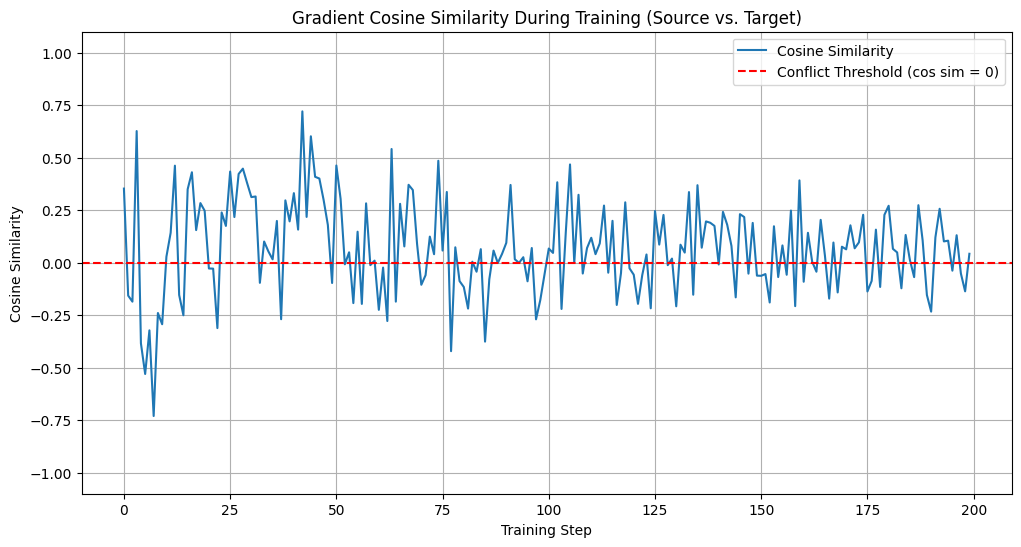

Analysis complete over 200 steps.
Observed conflict (cosine similarity < 0) in 77 steps (38.50%).
Average cosine similarity: 0.0682


In [ ]:
# STEP 2: Import libraries and run the experiment.
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import clip
import numpy as np
from tqdm.auto import tqdm
import random
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- Setup and Utilities (Same as before) ---

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

PACS_CLASS_NAMES = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

# --- Datasets (Same as before) ---

class CustomPACSDataset(Dataset):
    def __init__(self, examples, preprocess_fn):
        self.examples = examples
        self.preprocess = preprocess_fn
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        label = self.examples[idx].get("label", -1)
        image = self.preprocess(self.examples[idx]["image"].convert("RGB"))
        return image, label

class PseudoLabelDataset(Dataset):
    def __init__(self, pseudo_data, preprocess_fn):
        self.pseudo_data = pseudo_data
        self.preprocess = preprocess_fn
    def __len__(self):
        return len(self.pseudo_data)
    def __getitem__(self, idx):
        pil_image, pseudo_label = self.pseudo_data[idx]
        image = self.preprocess(pil_image)
        return image, pseudo_label

# --- CLIP and Prompt Learning Models (Corrected Implementation) ---

class PromptLearner(nn.Module):
    """
    Implements the learnable prompt vectors.
    This version correctly constructs prompts with a fixed length of 77.
    """
    def __init__(self, class_names, clip_model):
        super().__init__()
        n_cls = len(class_names)
        n_ctx = 16  # Number of context vectors (hyperparameter)
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]

        # --- Initialize the learnable context vectors (prompt) ---
        # Random initialization is standard for CoOp
        ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
        nn.init.normal_(ctx_vectors, std=0.02)
        self.ctx = nn.Parameter(ctx_vectors) # Shape: [n_ctx, ctx_dim]

        # --- Prepare the non-learnable parts of the prompt ---
        # Create full prompt templates with placeholder 'X's
        prompt_prefix = " ".join(["X"] * n_ctx)
        prompts = [prompt_prefix + " " + name + "." for name in class_names]

        # Tokenize the complete prompts
        self.tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(device)
        with torch.no_grad():
            # Get the initial embeddings for the tokenized prompts
            embedding = clip_model.token_embedding(self.tokenized_prompts).type(dtype)

        # Register non-learnable parts of the prompt as buffers
        self.register_buffer("token_prefix", embedding[:, :1, :])  # Start-of-sentence token
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :]) # Class name, EOS, and padding

        self.n_cls = n_cls
        self.n_ctx = n_ctx

    def forward(self):
        ctx = self.ctx # The learnable part, shape [n_ctx, ctx_dim]

        # Expand context to match the number of classes for broadcasting
        ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1) # Shape [n_cls, n_ctx, ctx_dim]

        prefix = self.token_prefix
        suffix = self.token_suffix

        # Stitch the learnable context vectors into the middle of the prompt embeddings
        prompts = torch.cat(
            [
                prefix,  # Shape: [n_cls, 1, ctx_dim]
                ctx,     # Shape: [n_cls, n_ctx, ctx_dim]
                suffix,  # Shape: [n_cls, 77-1-n_ctx, ctx_dim]
            ],
            dim=1,
        )
        return prompts

class CustomCLIP(nn.Module):
    """Wraps CLIP model and the PromptLearner with corrected text encoding."""
    def __init__(self, class_names, clip_model):
        super().__init__()
        self.prompt_learner = PromptLearner(class_names, clip_model)
        self.image_encoder = clip_model.visual
        # Store all necessary text components from the original CLIP model
        self.text_transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.token_embedding = clip_model.token_embedding # Needed by PromptLearner
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image):
        # Image Encoding (unchanged)
        image_features = self.image_encoder(image.type(self.dtype))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Text Encoding (using the correctly constructed prompts)
        prompts = self.prompt_learner() # Gets the stitched embeddings, shape [n_cls, 77, ctx_dim]
        tokenized_prompts = self.prompt_learner.tokenized_prompts # Gets token IDs, shape [n_cls, 77]

        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.text_transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # Extract features from the EOT token for each class prompt
        text_features = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)]
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Logit Calculation
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()
        return logits

# --- Core Gradient Analysis Function ---

def get_flattened_gradient(model, batch, criterion):
    """Computes, flattens, and returns the gradient for a single PRE-FETCHED batch."""
    # Set model to training mode to get gradients
    model.train()
    # Zero out any existing gradients
    model.zero_grad()

    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    # Forward pass and loss calculation
    logits = model(images)
    loss = criterion(logits, labels)

    # Backward pass to compute gradients
    loss.backward()

    # --- This is the key part ---
    # We iterate through ONLY the learnable prompt parameters,
    # flatten their gradients, and concatenate them into one long vector.
    grad_vecs = []
    with torch.no_grad():
        for param in model.prompt_learner.parameters():
            if param.grad is not None:
                grad_vecs.append(param.grad.view(-1))

    # Clear gradients for the next computation
    model.zero_grad()

    if not grad_vecs:
        return None

    return torch.cat(grad_vecs)

def analyze_gradient_conflict(source_loader, target_pseudo_loader):
    """Initializes a model and analyzes gradient conflict during training."""
    print("\n--- Analyzing Gradient Conflict ---")

    # Re-initialize model for a fresh analysis
    clip_model, _ = clip.load("ViT-B/16", device=device)
    for param in clip_model.parameters():
        param.requires_grad_(False)

    analysis_model = CustomCLIP(PACS_CLASS_NAMES, clip_model).to(device)
    optimizer = optim.SGD(analysis_model.prompt_learner.parameters(), lr=0.002)
    criterion = nn.CrossEntropyLoss()

    # Use iterators to manually pull one batch at a time from each loader
    source_iter = iter(source_loader)
    target_iter = iter(target_pseudo_loader)

    max_steps = 200 # Analyze for a fixed number of steps
    conflict_log = []

    for step in tqdm(range(max_steps), desc="Analyzing Gradients"):
        # --- Fetch one batch from each domain ---
        # Reset iterators if they are exhausted to continue sampling
        try:
            source_batch = next(source_iter)
        except StopIteration:
            source_iter = iter(source_loader)
            source_batch = next(source_iter)

        try:
            target_batch = next(target_iter)
        except StopIteration:
            target_iter = iter(target_pseudo_loader)
            target_batch = next(target_iter)

        # --- Gradient Calculation using the fetched batches ---
        grad_source = get_flattened_gradient(analysis_model, source_batch, criterion)
        grad_target = get_flattened_gradient(analysis_model, target_batch, criterion)

        if grad_source is None or grad_target is None:
            print("Gradient calculation failed.")
            break

        # --- Cosine Similarity Measurement ---
        cosine_sim = F.cosine_similarity(grad_source, grad_target, dim=0).item()
        conflict_log.append(cosine_sim)

        # --- Standard Training Step (using the same batches) ---
        analysis_model.train()
        optimizer.zero_grad()

        images_s, labels_s = source_batch
        images_t, labels_t = target_batch
        images_s, labels_s = images_s.to(device), labels_s.to(device)
        images_t, labels_t = images_t.to(device), labels_t.to(device)

        logits_s = analysis_model(images_s)
        logits_t = analysis_model(images_t)

        loss_s = criterion(logits_s, labels_s)
        loss_t = criterion(logits_t, labels_t)

        # The simplest way to combine is to just add the losses
        combined_loss = loss_s + loss_t
        combined_loss.backward()
        optimizer.step()

    # --- Plot the results ---
    plt.figure(figsize=(12, 6))
    plt.plot(conflict_log, label='Cosine Similarity')
    plt.axhline(y=0, color='r', linestyle='--', label='Conflict Threshold (cos sim = 0)')
    plt.title('Gradient Cosine Similarity During Training (Source vs. Target)')
    plt.xlabel('Training Step')
    plt.ylabel('Cosine Similarity')
    plt.ylim(-1.1, 1.1)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Report key findings
    conflict_log = np.array(conflict_log)
    num_conflicts = np.sum(conflict_log < 0)
    print(f"Analysis complete over {len(conflict_log)} steps.")
    print(f"Observed conflict (cosine similarity < 0) in {num_conflicts} steps ({num_conflicts/len(conflict_log):.2%}).")
    print(f"Average cosine similarity: {np.mean(conflict_log):.4f}")

# --- Conceptual: A Simple Gradient Alignment Strategy ---

def gradient_averaging_on_conflict(grad_source, grad_target):
    """
    A simple, conceptual approach to align gradients.
    This is NOT for execution, but for explaining the concept in a report.
    """
    cosine_sim = F.cosine_similarity(grad_source, grad_target, dim=0)

    if cosine_sim < 0:
        # CONFLICT DETECTED!
        # The advice from the two domains disagrees.
        # A simple, safe compromise is to move in the average direction.
        # This update is not perfect for either domain, but it won't
        # actively harm one to help the other.
        print("Conflict detected! Applying Gradient Averaging.")
        final_grad = (grad_source + grad_target) / 2.0
    else:
        # NO CONFLICT.
        # The advice is aligned or at least not contradictory.
        # We can be more aggressive and combine their strengths by adding them.
        print("Gradients aligned. Applying standard update.")
        final_grad = grad_source + grad_target

    # In a real implementation, you would then manually apply this
    # `final_grad` to the model's parameters.
    return final_grad


if __name__ == '__main__':
    # --- Data Preparation (Same as previous step) ---
    clip_model, clip_preprocess = clip.load("ViT-B/16", device=device)
    pacs_dataset = load_dataset("flwrlabs/pacs")["train"]
    source_domain, target_domain = "photo", "sketch"

    # We need the pseudo-labeled data from the last step
    print("Preparing data... (This reuses logic from the previous step)")
    source_examples = [ex for ex in pacs_dataset if ex["domain"] == source_domain]
    target_examples = [ex for ex in pacs_dataset if ex["domain"] == target_domain]

    # Create a temporary teacher model to get pseudo-labels
    teacher_model = CustomCLIP(PACS_CLASS_NAMES, clip_model).to(device)
    # NOTE: In a real scenario, you'd load your trained teacher.
    # For this isolated analysis, a pre-trained CLIP is a good-enough proxy.

    # Helper to generate pseudo labels (simplified for this script)
    @torch.no_grad()
    def get_pseudo_labels(model, examples, preprocess, threshold=0.95):
        dataset = CustomPACSDataset(examples, preprocess)
        loader = DataLoader(dataset, batch_size=64)
        confident_data = []
        for images, _ in tqdm(loader, desc="Generating pseudo-labels"):
            images = images.to(device)
            logits = model(images)
            probs, labels = logits.softmax(dim=-1).max(dim=-1)
            for i in range(len(probs)):
                if probs[i] > threshold:
                    # Find original PIL image
                    pil_image = examples[i + len(confident_data) * 64]['image']
                    confident_data.append((pil_image, labels[i].item()))
        return confident_data

    # pseudo_data = get_pseudo_labels(teacher_model, target_examples, clip_preprocess)
    # Using a placeholder to avoid re-running the full teacher training for this analysis
    # A real run would use the actual pseudo-labels from the previous step.
    # Let's create some dummy pseudo-data for demonstration.
    pseudo_data = [(ex['image'], ex['label']) for ex in target_examples[:1000]] # Use first 1000 target examples as proxy

    source_loader = DataLoader(CustomPACSDataset(source_examples, clip_preprocess), batch_size=32, shuffle=True)
    pseudo_loader = DataLoader(PseudoLabelDataset(pseudo_data, clip_preprocess), batch_size=32, shuffle=True)

    # --- Run the Analysis ---
    analyze_gradient_conflict(source_loader, pseudo_loader)

Task 4


Using device: cuda

--- Analyzing Zero-Shot CLIP (Generalist) ---


Calculating MSP Scores:   0%|          | 0/123 [00:00<?, ?it/s]

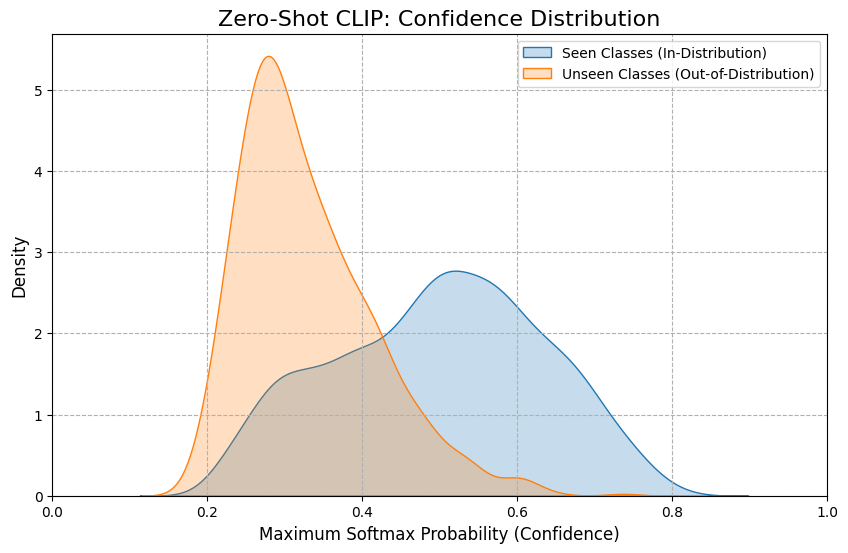


--- Training Prompt-Tuned CLIP (Specialist) on Seen Classes ---


Epoch 1/10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 complete.


Epoch 2/10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 complete.


Epoch 3/10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 complete.


Epoch 4/10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 complete.


Epoch 5/10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 complete.


Epoch 6/10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 complete.


Epoch 7/10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 complete.


Epoch 8/10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 complete.


Epoch 9/10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 complete.


Epoch 10/10:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 complete.

--- Analyzing Prompt-Tuned CLIP (Specialist) ---


Calculating MSP Scores:   0%|          | 0/123 [00:00<?, ?it/s]

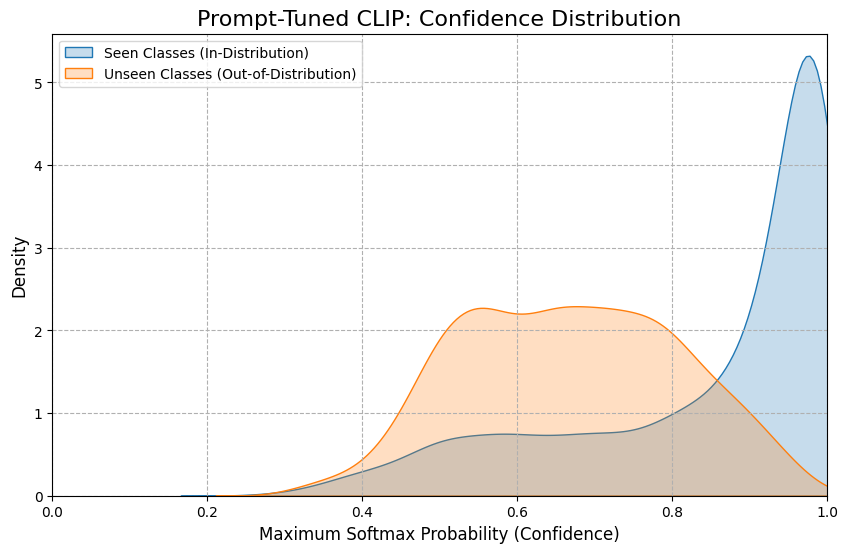



===== Open-Set Analysis Summary =====
Average confidence on SEEN classes (Zero-Shot):   0.4983
Average confidence on UNSEEN classes (Zero-Shot): 0.3297
----------------------------------------
Average confidence on SEEN classes (Tuned):     0.8485
Average confidence on UNSEEN classes (Tuned):   0.6671


In [ ]:
# STEP 2: Import libraries and run the experiment.
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import clip
import numpy as np
from tqdm.auto import tqdm
import random
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup and Utilities ---

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Open-Set Class Definitions ---
ALL_CLASS_NAMES = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
SEEN_CLASS_NAMES = ['dog', 'elephant', 'giraffe', 'horse', 'house'] # The "closed world"
UNSEEN_CLASS_NAMES = ['guitar', 'person'] # The novel, "open-set" classes

# --- Datasets ---

class CustomPACSDataset(Dataset):
    def __init__(self, examples, preprocess_fn):
        self.examples = examples
        self.preprocess = preprocess_fn
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        label = self.examples[idx]["label"]
        image = self.preprocess(self.examples[idx]["image"].convert("RGB"))
        return image, label

# --- CLIP and Prompt Learning Models (Corrected) ---

class PromptLearner(nn.Module):
    def __init__(self, class_names, clip_model):
        super().__init__()
        n_cls, n_ctx = len(class_names), 16
        dtype, ctx_dim = clip_model.dtype, clip_model.ln_final.weight.shape[0]
        ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
        nn.init.normal_(ctx_vectors, std=0.02)
        self.ctx = nn.Parameter(ctx_vectors)
        prompt_prefix = " ".join(["X"] * n_ctx)
        prompts = [prompt_prefix + " " + name + "." for name in class_names]
        self.tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(self.tokenized_prompts).type(dtype)
        self.register_buffer("token_prefix", embedding[:, :1, :])
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])
        self.n_cls, self.n_ctx = n_cls, n_ctx
    def forward(self):
        ctx = self.ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        return torch.cat([self.token_prefix, ctx, self.token_suffix], dim=1)

class CustomCLIP(nn.Module):
    def __init__(self, class_names, clip_model):
        super().__init__()
        self.prompt_learner = PromptLearner(class_names, clip_model)
        self.image_encoder, self.text_transformer = clip_model.visual, clip_model.transformer
        self.positional_embedding, self.ln_final = clip_model.positional_embedding, clip_model.ln_final
        self.token_embedding = clip_model.token_embedding
        self.logit_scale, self.dtype = clip_model.logit_scale, clip_model.dtype
    def forward(self, image):
        # Image encoding with CORRECT normalization
        image_features = self.image_encoder(image.type(self.dtype))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Text encoding
        prompts = self.prompt_learner()
        tokenized_prompts = self.prompt_learner.tokenized_prompts
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)
        x = self.text_transformer(x)
        x = x.permute(1, 0, 2)
        x = self.ln_final(x).type(self.dtype)

        # Text encoding with CORRECT normalization
        text_features = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)]
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Logit calculation
        return self.logit_scale.exp() * image_features @ text_features.t()

# --- Analysis and Visualization Functions ---

@torch.no_grad()
def get_msp_scores(model, loader, seen_class_ids):
    """Calculates MSP scores and separates them for seen vs. unseen classes."""
    model.eval()
    seen_scores, unseen_scores = [], []
    for images, labels in tqdm(loader, desc="Calculating MSP Scores"):
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        probs = logits.softmax(dim=-1)
        msp, _ = probs.max(dim=-1)

        for i in range(len(labels)):
            if labels[i].item() in seen_class_ids:
                seen_scores.append(msp[i].item())
            else:
                unseen_scores.append(msp[i].item())
    return seen_scores, unseen_scores

def plot_msp_distributions(results, title):
    """Plots the MSP score distributions for seen and unseen classes."""
    plt.figure(figsize=(10, 6))
    sns.kdeplot(results['seen'], label='Seen Classes (In-Distribution)', fill=True, warn_singular=False)
    sns.kdeplot(results['unseen'], label='Unseen Classes (Out-of-Distribution)', fill=True, warn_singular=False)
    plt.title(title, fontsize=16)
    plt.xlabel('Maximum Softmax Probability (Confidence)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.xlim(0, 1)
    plt.grid(True, linestyle='--')
    plt.show()

# --- Main Experiment ---

if __name__ == '__main__':
    # 1. Load Model and Data
    clip_model, clip_preprocess = clip.load("ViT-B/16", device=device)
    pacs_dataset = load_dataset("flwrlabs/pacs")["train"]
    source_domain, target_domain = "photo", "sketch"

    # 2. Prepare Datasets based on class splits
    seen_class_ids = [ALL_CLASS_NAMES.index(c) for c in SEEN_CLASS_NAMES]

    # Training data: source domain, ONLY seen classes
    train_examples = [ex for ex in pacs_dataset if ex["domain"] == source_domain and ex["label"] in seen_class_ids]
    train_dataset = CustomPACSDataset(train_examples, clip_preprocess)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Test data: target domain, ALL classes
    test_examples = [ex for ex in pacs_dataset if ex["domain"] == target_domain]
    test_dataset = CustomPACSDataset(test_examples, clip_preprocess)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # 3. Analyze Baseline: Zero-Shot CLIP ("The Generalist")
    print("\n--- Analyzing Zero-Shot CLIP (Generalist) ---")
    # Note: We create a new clip_model instance to ensure fresh, untuned weights for zero-shot
    clip_model_zs, _ = clip.load("ViT-B/16", device=device)
    zero_shot_model = CustomCLIP(ALL_CLASS_NAMES, clip_model_zs).to(device) # Uses all 7 class names
    zs_seen_scores, zs_unseen_scores = get_msp_scores(zero_shot_model, test_loader, seen_class_ids)
    plot_msp_distributions({'seen': zs_seen_scores, 'unseen': zs_unseen_scores}, 'Zero-Shot CLIP: Confidence Distribution')

    # 4. Train the Prompt-Tuned "Specialist" Model
    print("\n--- Training Prompt-Tuned CLIP (Specialist) on Seen Classes ---")
    specialist_model = CustomCLIP(SEEN_CLASS_NAMES, clip_model).to(device) # Uses only 5 class names
    optimizer = optim.SGD(specialist_model.prompt_learner.parameters(), lr=0.002)
    criterion = nn.CrossEntropyLoss()

    # Freeze CLIP backbone
    for name, param in specialist_model.named_parameters():
        if "prompt_learner" not in name:
            param.requires_grad_(False)

    for epoch in range(10): # A full training run
        specialist_model.train()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/10"):
            # Remap labels from global [0-6] to local [0-4] for the 5-class classifier
            local_labels = [seen_class_ids.index(l.item()) for l in labels]
            local_labels = torch.tensor(local_labels).to(device)
            images = images.to(device)

            optimizer.zero_grad()
            logits = specialist_model(images)
            loss = criterion(logits, local_labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} complete.")

    # 5. Analyze the "Specialist" Model
    print("\n--- Analyzing Prompt-Tuned CLIP (Specialist) ---")
    pt_seen_scores, pt_unseen_scores = get_msp_scores(specialist_model, test_loader, seen_class_ids)
    plot_msp_distributions({'seen': pt_seen_scores, 'unseen': pt_unseen_scores}, 'Prompt-Tuned CLIP: Confidence Distribution')

    print("\n\n===== Open-Set Analysis Summary =====")
    print(f"Average confidence on SEEN classes (Zero-Shot):   {np.mean(zs_seen_scores):.4f}")
    print(f"Average confidence on UNSEEN classes (Zero-Shot): {np.mean(zs_unseen_scores):.4f}")
    print("-" * 40)
    print(f"Average confidence on SEEN classes (Tuned):     {np.mean(pt_seen_scores):.4f}")
    print(f"Average confidence on UNSEEN classes (Tuned):   {np.mean(pt_unseen_scores):.4f}")